# PES_1D-Discriminator

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from pes_1D.data_generator import generate_discriminator_training_set  # type: ignore
from pes_1D.discriminator import NaiveDiscriminator  # type: ignore
from pes_1D.training import test_model, train_model  # type: ignore
from pes_1D.utils import get_model_failure_info  # type: ignore
from pes_1D.visualization import sample_visualization  # type: ignore

<Axes: xlabel='r'>

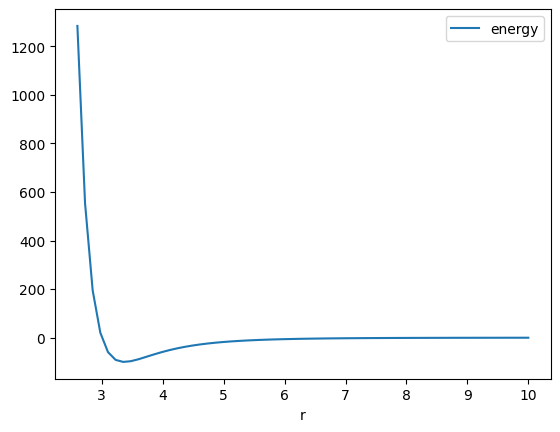

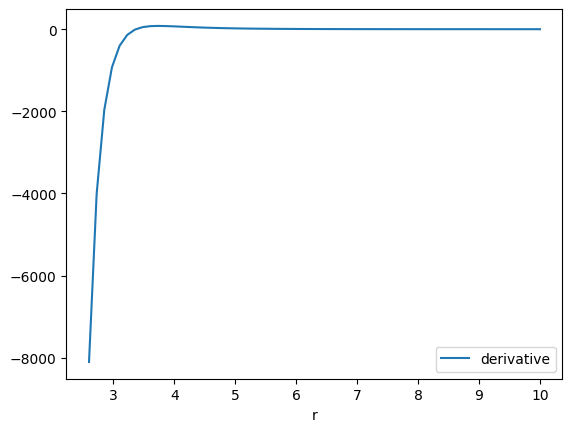

In [2]:
from pes_1D.utils import PesModels
import matplotlib.pyplot as plt
df = PesModels.lennard_jones_pes(3.0, 100.0, 2.6, 10, 60)

df.plot(x="r",y="energy")
df.plot(x="r", y="derivative")

### parameters

In [3]:
in_features = 64
n_samples = 2000
test_split = 0.5
gpu = True

### Generate training and test sets 

In [4]:
X_train, y_train, X_test, y_test, df_samples = generate_discriminator_training_set(
    n_samples, in_features, test_split, gpu, generator_seed=[36, 25]
)

df_samples.drop(columns=['pes','parameters','deformation_parameters']).head(10)

#sample_visualization(df_samples)

,model_type,true_pes,modified_pes,deformation_type
0,lennard_jones,1,0,
1,twisted_lennard_jones,0,1,outliers
2,lennard_jones,1,0,
3,lennard_jones,1,0,
4,twisted_lennard_jones,0,1,outliers
5,twisted_lennard_jones,0,1,oscillation
6,twisted_lennard_jones,0,1,oscillation
7,twisted_lennard_jones,0,1,oscillation
8,lennard_jones,1,0,
9,lennard_jones,1,0,


### Discriminator model definition

In [5]:
model = NaiveDiscriminator(in_features, 64, 64, 64, 2)
model = model.to("cuda" if gpu else "cpu")  # x = self.dropout(x)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

Training the model...
Epoch 0, Loss: 2.446181535720825
Epoch 10, Loss: 0.8438422083854675
Epoch 20, Loss: 0.6841498017311096
Epoch 30, Loss: 0.6340602040290833
Epoch 40, Loss: 0.602260410785675
Epoch 50, Loss: 0.5723457932472229
Epoch 60, Loss: 0.5897365808486938
Epoch 70, Loss: 0.5466831922531128
Epoch 80, Loss: 0.6195411086082458
Epoch 90, Loss: 0.5715789198875427
Epoch 100, Loss: 0.5565028190612793
Epoch 110, Loss: 0.5839177966117859
Epoch 120, Loss: 0.5552051663398743
Epoch 130, Loss: 0.5639195442199707
Epoch 140, Loss: 0.6482977271080017
Epoch 150, Loss: 0.6841569542884827
Epoch 160, Loss: 0.5920301079750061
Epoch 170, Loss: 0.6751607060432434
Epoch 180, Loss: 0.6050670742988586
Epoch 190, Loss: 0.5896831750869751
Epoch 200, Loss: 0.5625599026679993
Epoch 210, Loss: 0.6261037588119507
Epoch 220, Loss: 0.5895209312438965
Epoch 230, Loss: 0.5684857964515686
Epoch 240, Loss: 0.5496888160705566
Epoch 250, Loss: 0.5393930077552795
Epoch 260, Loss: 0.5829969048500061
Epoch 270, Loss: 0.

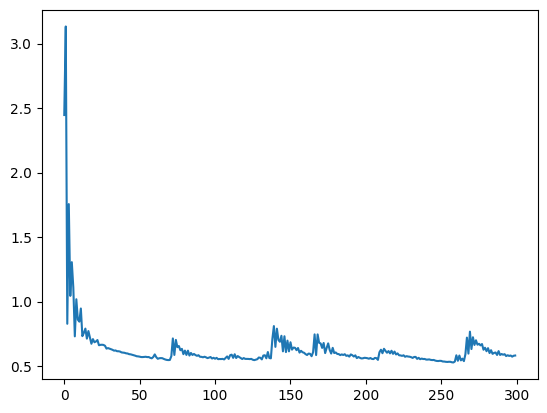

Evaluation:
Test Loss: 0.5563135147094727
Accuracy (%):  72.2


In [6]:
epochs = 300

# Train the model
print("Training the model...")
losses = train_model(X_train, y_train, model, criterion, optimizer, epochs,verbose=True)

print(f"Training Losses:{losses[-1]}")
plt.plot(range(epochs), losses)
plt.show()

# Test the model
test_loss, accuracy = test_model(X_test, y_test, model, criterion)

### Get model failure information

Confusion Matrix:  Confusion Matrix
[[214 270]
 [  8 508]]


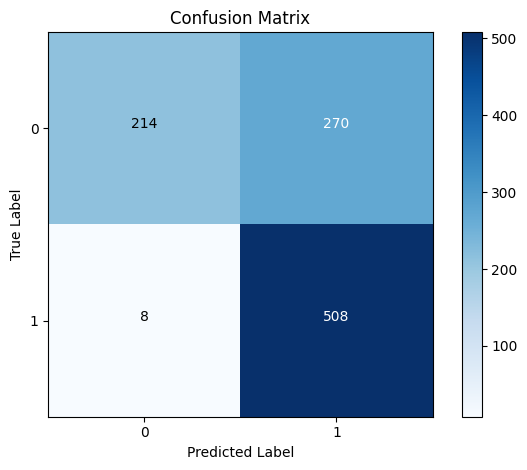



Failure Distribution by Deformation Type:
deformation_type
oscillation    188
outliers       82
                8
Name: count, dtype: int64




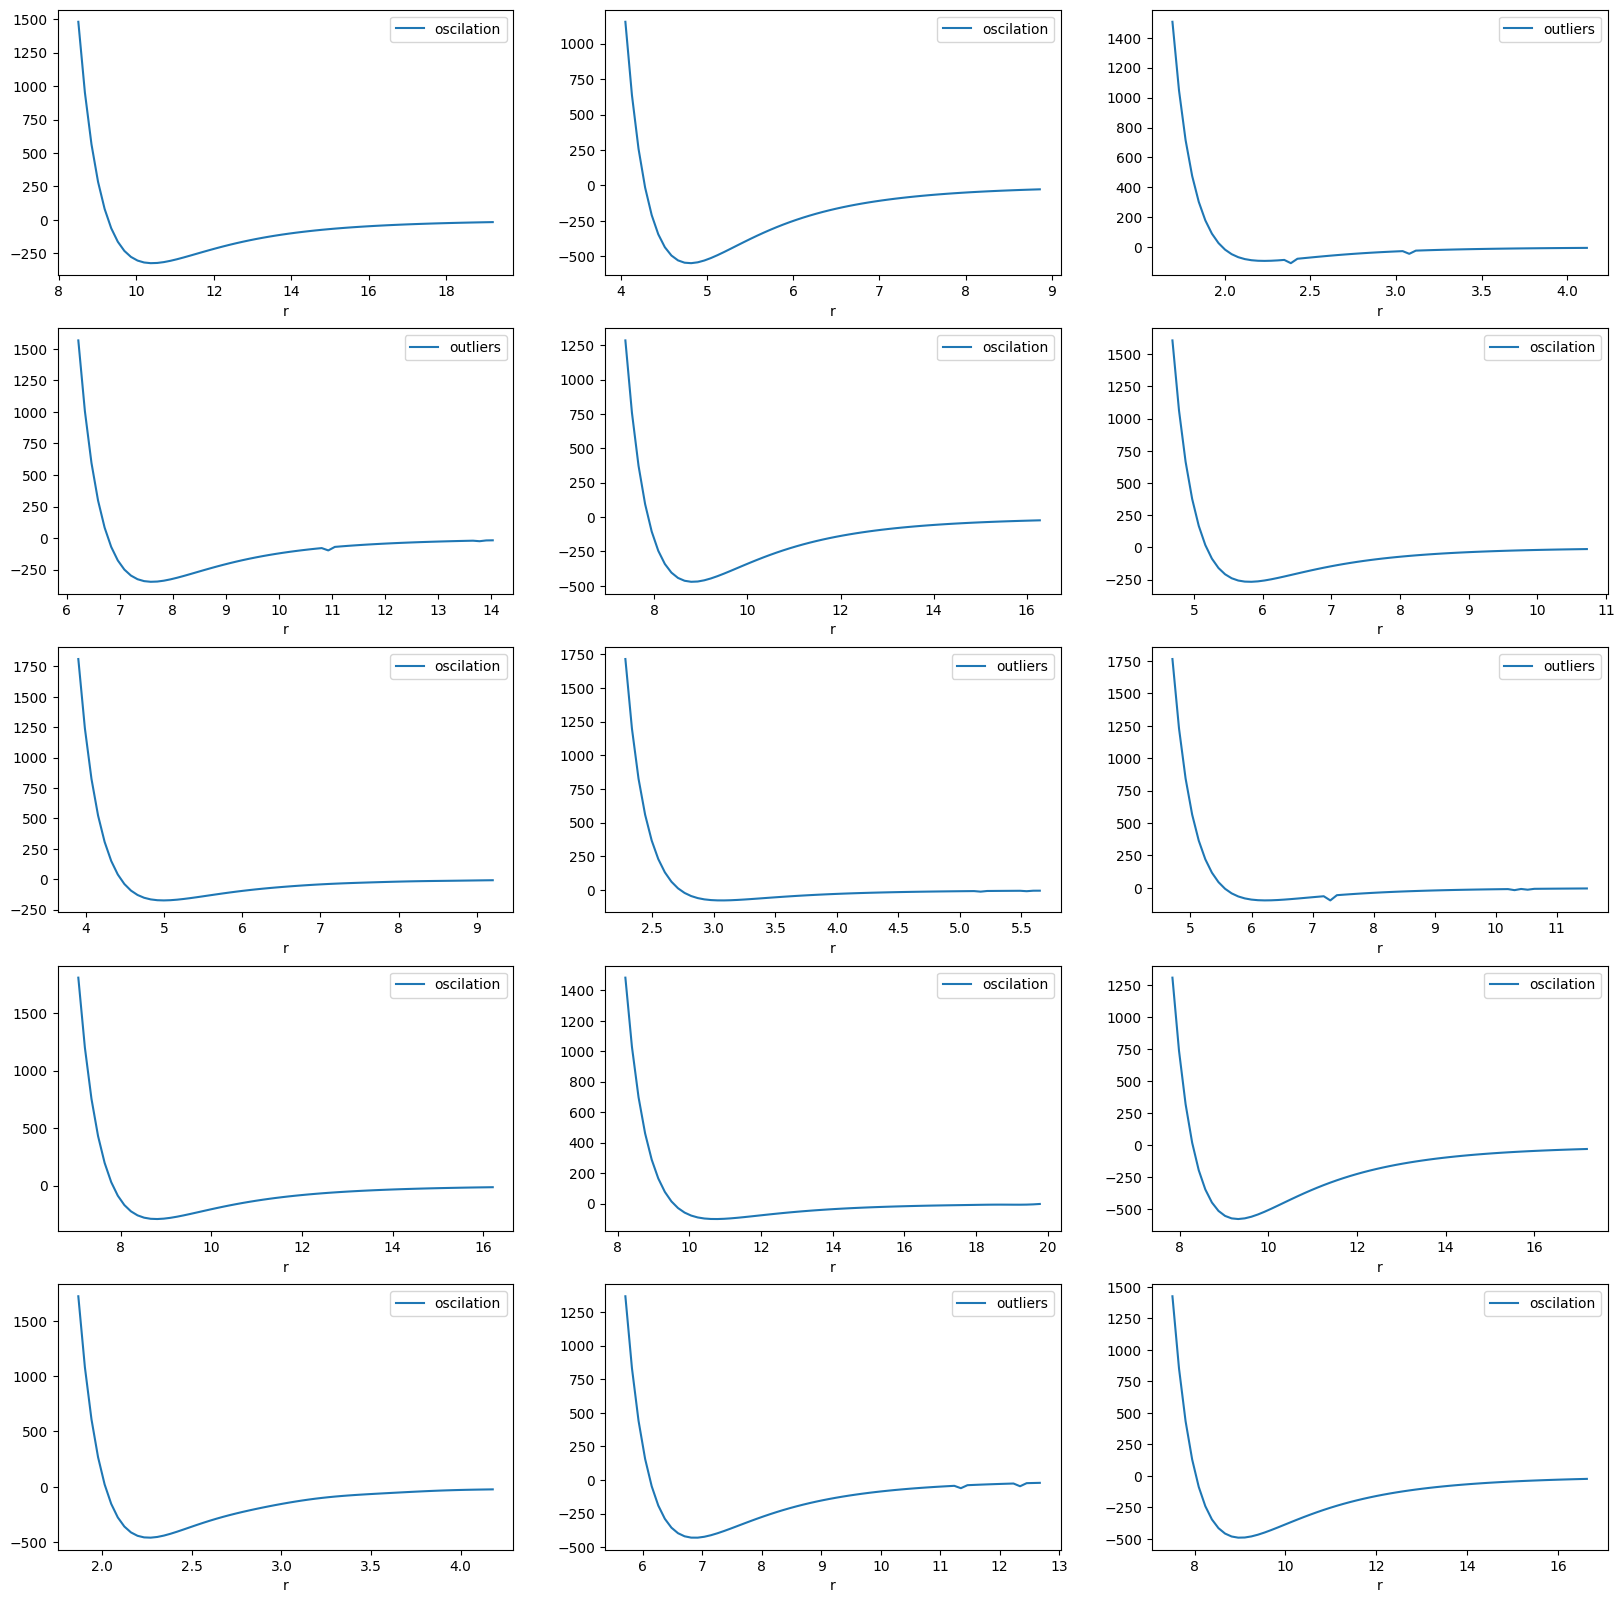

In [7]:
df_train = df_samples[df_samples.index < n_samples - int(n_samples * test_split)]
df_test = df_samples[df_samples.index >= n_samples - int(n_samples * test_split)]


get_model_failure_info(df_test, X_test, y_test, model)